In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pickle
from mutation import *
from crossover import *
from rmp import *
from mfea import *
from task import *
from llm import *
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

In [2]:
load_dotenv()

DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")

deepseek = DeepseekModel(DEEPSEEK_API_KEY, "deepseek-chat", 1.0)

In [3]:
gnbg_tasks = []
gnbg_tasks.append(GNBGTask(1))
gnbg_tasks.append(GNBGTask(2))

In [4]:
num_p = 10
dim = 30
p1 = np.random.uniform(-100, 100, size=(num_p, dim))
p2 = np.random.uniform(-100, 100, size=(num_p, dim))
p1_skill_factor = np.random.randint(0, 2, size=num_p)
p2_skill_factor = np.random.randint(0, 2, size=num_p)

In [5]:
tasks = []
tasks.append(CEC17Task(1))
tasks.append(CEC17Task(3))

In [6]:
x = np.random.uniform(-1, 1, size=5)
x.shape

(5,)

In [7]:
num_indis_per_task = 200
indi_len = 50
bound = 100
crossover = BLXCrossover()
mutation = PolynomialMutation(20, bound)
rmp = AdaptiveRMP(rmp_pop_size=3, num_gen=1, pc=0.8, pm=0.1)
amfea = AMFEA(num_indis_per_task, indi_len, bound, tasks, crossover, mutation, rmp)

Initialization:
Task 0:
Best Fitness: 2483615339534.5303
Mean Fitness: 4052911705175.011

Task 1:
Best Fitness: 25434566.49507395
Mean Fitness: 1.4905663067131422e+16



In [ ]:
bfs, mfs = amfea.fit(5000, monitor=False, monitor_rate=50, llm_rate=500)

Creating 3 ideas
RMP function:
 import numpy as np
import numpy as np

def get_rmp(p1, p2, p1_skill_factor, p2_skill_factor, p1_fitness, p2_fitness):
    skill_similarity = np.exp(-np.abs(p1_skill_factor - p2_skill_factor))
    fitness_ratio = np.maximum(p1_fitness, p2_fitness) / (p1_fitness + p2_fitness + 1e-10)
    normalized_fitness = 0.5 + (fitness_ratio - 0.5) * 0.2
    rmp = skill_similarity * normalized_fitness
    return np.clip(rmp, 0.0, 1.0)
RMP shape: (82,)
RMP array:
 [0.50283808 0.21227024 0.22070944 0.51971511 0.22034004 0.59902871
 0.50898907 0.59986056 0.58669047 0.22067422 0.22063477 0.22067346
 0.50976977 0.22072705 0.5608763  0.21824736 0.21901176 0.56519691
 0.21832908 0.59983462 0.22065525 0.22056015 0.21966034 0.22071472
 0.5899159  0.50539502 0.20755312 0.2206972  0.22065582 0.21068853
 0.22062102 0.22071969 0.50454224 0.21476408 0.22070715 0.22070101
 0.5047946  0.51819213 0.50687792 0.22071982 0.59817881 0.21867457
 0.59142625 0.22066271 0.52777091 0.59188921 0

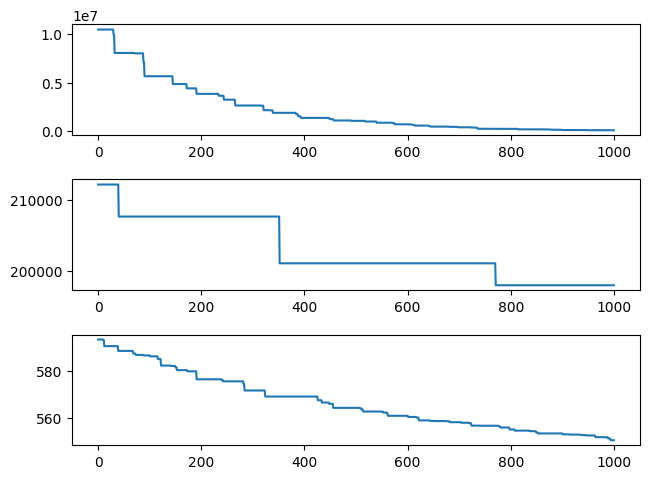

In [ ]:
num_tasks = len(tasks)
fig, axes = plt.subplots(num_tasks, 2)
fig.tight_layout()
for i in range(num_tasks):
    axes[i][0].plot(bfs[i])
    axes[i][1].plot(mfs[i])

In [3]:
ideas = deepseek.initial_ideas(3)

Creating 3 ideas


In [4]:
print(ideas[0])
print(ideas[1])
print(ideas[2])

Use a sigmoid-based RMP that adjusts based on the difference in skill factors, where parents with similar skill factors have higher RMP, but the fitness scores modulate the steepness of the sigmoid to allow more exploration when fitness differences are small.
Incorporate a dynamic thresholding mechanism where RMP is high if both parents belong to the same skill factor, but if they differ, the RMP decays exponentially with the absolute difference in fitness, scaled by the ratio of their skill factors.
Design a hybrid RMP that combines a base probability (from skill factor similarity) with a perturbation term derived from the normalized fitness ratio, ensuring that even dissimilar parents can mate if their fitness scores are highly complementary.


In [5]:
code = deepseek.idea_to_code_function(ideas[0])
print(code)

def get_rmp(p1, p2, p1_skill_factor, p2_skill_factor, p1_fitness, p2_fitness):  
    skill_diff = np.abs(p1_skill_factor - p2_skill_factor)  
    normalized_skill_diff = skill_diff / np.max(skill_diff + 1e-10)  
    fitness_diff = np.abs(p1_fitness - p2_fitness)  
    normalized_fitness_diff = fitness_diff / (np.max(fitness_diff) + 1e-10)  
    steepness = 10.0 * (1.0 - normalized_fitness_diff)  
    rmp = 1.0 / (1.0 + np.exp(steepness * (normalized_skill_diff - 0.5)))  
    return rmp
